# Predicting Titanic Survivals

Modelagem de uma rede neural para prever sobrevivência do Navio Titanic. Fonte dos dados: https://www.kaggle.com/c/titanic

**Alunos:**

- Davi P. Neto
- Giovane N. M. Costa
- Henrique A. Batochi


Referências: 

https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2

https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish

http://scikit-learn.org/stable/modules/neural_networks_supervised.html


## Dicionário de Dados

**Variable:	Definition	Key**

**survival:**	Survival	0 = No, 1 = Yes

**pclass:**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

**sex:**	Sex	(female or male)

**Age:**	Age in years	

**sibsp:**	# of siblings / spouses aboard the Titanic	

**parch:**	# of parents / children aboard the Titanic	

**ticket:**	Ticket number	

**fare:**	Passenger fare	

**cabin:**	Cabin number	

**embarked:**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


**Variable Notes**

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: Some children travelled only with a nanny, therefore parch=0 for them.
Parent = mother, father
Child = daughter, son, stepdaughter, stepson

## Importando Bibliotecas

In [1]:
import numpy as np # Para trabalhar com vetores e fazer outras operações matemáticas
import pandas as pd # Pandas Dataframe: processamento de dados
import matplotlib.pyplot as plt # Matplot: gráficos
import seaborn as sns #Seaborn: simplica o processo de criar gráficos

# Abrir os graficos no navegador em vez de em outra janela
%matplotlib inline

#Sci-kit Learn: biblioteca de machine learning para python, da qual importamos rede neural (Multilayer Perceptron)
from sklearn.neural_network import MLPClassifier 

## Importando o Dataset

In [2]:
# Criamos um Pandas Dataframe a partir do csv. 
# Dataframe é tipo uma Classe para tabelas com várias funções de manipulação
data = pd.read_csv('train.csv')

In [3]:
# Pegamos 15 amostras dos dados para dar uma olhada
data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
430,431,1,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28.0,0,0,110564,26.5500,C52,S
667,668,0,3,"Rommetvedt, Mr. Knud Paust",male,NaN,0,0,312993,7.7750,NaN,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C
228,229,0,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S
315,316,1,3,"Nilsson, Miss. Helmina Josefina",female,26.0,0,0,347470,7.8542,NaN,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
716,717,1,1,"Endres, Miss. Caroline Louise",female,38.0,0,0,PC 17757,227.5250,C45,C
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S


In [4]:
# Estatística básica dos campos numericos do Dataframe
# Apenas 38% das pessoas sobreviveram
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Tratando os dados

### Checando por dados ausentes

As variáveis Idade, Cabine e Local de Embarque precisam ser preenchidas

In [5]:
data.apply(lambda x: sum(x.isnull()),axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Idade

Segundo o dataset, existem idades "quebradas (x.5) que foram estimadas, idades 1 (bebes) e idades ausentes. Para facilitar a análise, preenchemos as idades ausentes com a mediana e as separamos as idades por categorias:

Bebê (0 a 5), Criança (5 a 12), Adolescente (12 a 18), Jovem (18 a 25), Jovem Adulto (25 a 35), Adulto (35 a 60), Idoso (60 a 81)

In [6]:
print data.Age.sort_values().unique()
print data.Age.median()

[  0.42   0.67   0.75   0.83   0.92   1.     2.     3.     4.     5.     6.
   7.     8.     9.    10.    11.    12.    13.    14.    14.5   15.    16.
  17.    18.    19.    20.    20.5   21.    22.    23.    23.5   24.    24.5
  25.    26.    27.    28.    28.5   29.    30.    30.5   31.    32.    32.5
  33.    34.    34.5   35.    36.    36.5   37.    38.    39.    40.    40.5
  41.    42.    43.    44.    45.    45.5   46.    47.    48.    49.    50.
  51.    52.    53.    54.    55.    55.5   56.    57.    58.    59.    60.
  61.    62.    63.    64.    65.    66.    70.    70.5   71.    74.    80.
    nan]
28.0


In [7]:
# Preenchemos as idades ausentes com valores negativos com a mediana
data.Age = data.Age.fillna(28)

# limites dos grupos
bins = (0, 5, 12, 18, 25, 35, 60, 120)

#nomes dos grupos
grupos = ['Bebê'.decode('utf-8'), 'Criança'.decode('utf-8'), 'Adolescente', 
          'Jovem', 'Jovem Adulto', 'Adulto', 'Idoso']

# Cada linha do dataframe tem um indice que a identifica.
# Pd.cut faz a categorização atribuindo uma categoria para cada indice
categorias = pd.cut(data.Age, bins, labels=grupos)

# Atualizamos o campo idade do dataframe com o novo vetor criado
data.Age = categorias

### Cabine

Todas as cabines começam como uma letra, que vão de 'A' a 'G', e uma 'T' . Essa letra pode ser interessante, por isso a separamos dos números e jogamos eles fora. Além disso, também existem valores ausentes que preenchemos com a letra 'N'.

In [8]:
# Preenchendo valores ausentes
data.Cabin = data.Cabin.fillna('N')

# Substituindo a Cabine pela primeira letra
data.Cabin = data.Cabin.apply(lambda x: x[0])

print data.Cabin.value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


### Tarifa
Simplificamos também as tarifas dividindo em 4 grupos conforme quartis.
(Um quartil é qualquer um dos três valores que divide o conjunto ordenado de dados em quatro partes iguais, e assim cada parte representa 1/4 da amostra ou população /Wikipedia)

In [9]:
data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [10]:
# Preenchendo os valores ausentes
data.Fare = data.Fare.fillna(-0.5)

# Limites dos quartis conforme a função describe()
bins = (-1, 0, 8, 15, 31, 513)

# Nome dos grupos
grupos = ['Desconhecido', '1_Quartil', '2_Quartil', '3_Quartil', '4_Quartil']

# Divisão das categorias
categorias = pd.cut(data.Fare, bins, labels=grupos)

# Atualizando a coluna
data.Fare = categorias

### Nome
É razoável admitir que o nome de uma pessoa não interefere na probabilidade de sobrevivência dela. No entanto, o prefixo (Mr. Miss, etc..) pode dizer alguma coisa, pois está relacionado ao sexo e estado civíl.

In [11]:
# Ex: Reeves, Mr. David

# Pegando o prefixo
data['NamePrefix'] = data.Name.apply(lambda x: x.split(' ')[1])

### Familia
Vamos criar uma variavel familia somando a SibSp e Parch

In [12]:
data['Family'] = data['SibSp'] + data['Parch']

### Local de Embarque
A maioria embarcou em Southampton, então vamos preencher os valores com esse local

In [13]:
# Preenchendo valores ausentes
print data['Embarked'].value_counts()
data.Embarked = data.Embarked.fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64


### Eliminando Features

Por fim, eliminamos as features irrelevantes para o aprendizado, como o número da passagem, o nome, e o local onde embarcou.

In [14]:
data = data.drop(['PassengerId', 'Ticket', 'Name', 'SibSp', 'Parch'], axis=1)
data.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,NamePrefix,Family
0,0,3,male,Jovem,1_Quartil,N,S,Mr.,1
1,1,1,female,Adulto,4_Quartil,C,C,Mrs.,1
2,1,3,female,Jovem Adulto,1_Quartil,N,S,Miss.,0
3,1,1,female,Jovem Adulto,4_Quartil,C,S,Mrs.,1
4,0,3,male,Jovem Adulto,2_Quartil,N,S,Mr.,0


## Análise Exploratória

Plotamos alguns gráficos para ver como nossas varíaveis se relacionam com a sobrevivência:

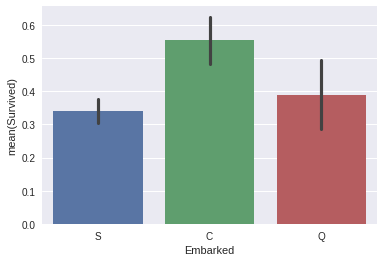

In [15]:
sns.barplot(x="Embarked", y="Survived", data=data);

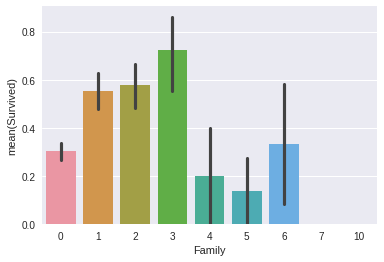

In [16]:
sns.barplot(x="Family", y="Survived", data=data);

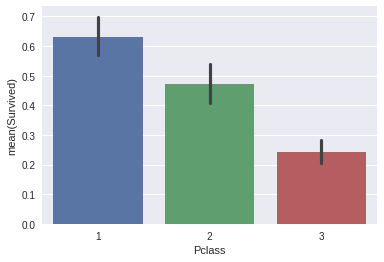

In [17]:
sns.barplot(x="Pclass", y="Survived", data=data);

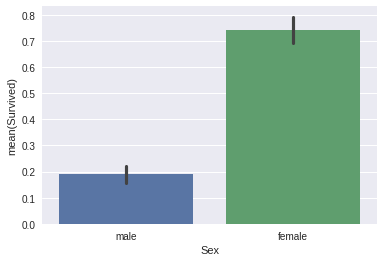

In [18]:
sns.barplot(x="Sex", y="Survived", data=data);

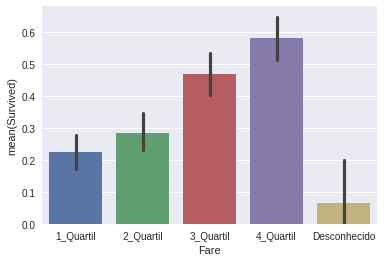

In [19]:
sns.barplot(x="Fare", y="Survived", data=data);

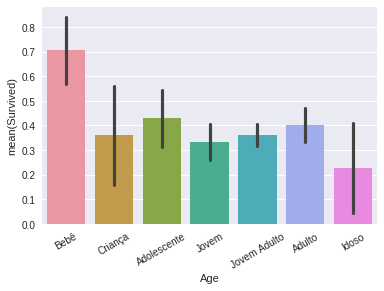

In [20]:
ordem = ['Bebê'.decode('utf-8'), 'Criança'.decode('utf-8'), 'Adolescente', 
          'Jovem', 'Jovem Adulto', 'Adulto', 'Idoso']
plt.xticks(rotation=30)
sns.barplot(x="Age", y="Survived", order=ordem, data=data);

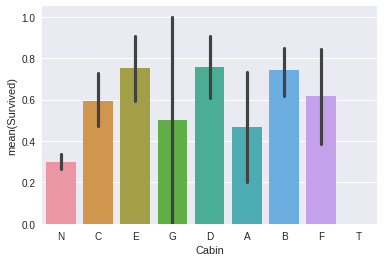

In [21]:
sns.barplot(x="Cabin", y="Survived", data=data);

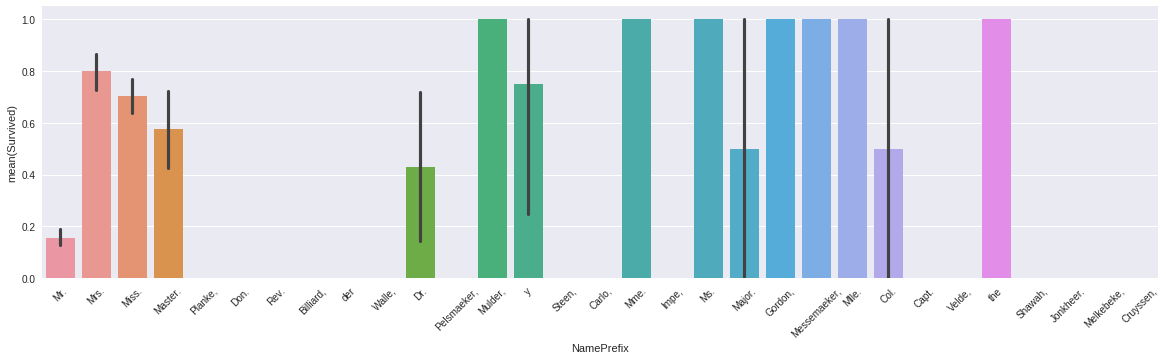

In [22]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
sns.barplot(x="NamePrefix", y="Survived", data=data)

Como podemos ver, algumas características se destacam, como:
- Familia: pessoas viajando sozinhas ou com mais de 3 familiares tem menos chance de sobreviver;
- Sexo: mulheres tem mais chance de sobreviver;
- Classe: quanto menor a classe, melhor a chance de sobreviver;
- Tarifa: passageiros que pagaram mais tem mais chance de sobreviver;
- Idade: idosos, jovens e crianças foram os que menos sobreviveram;    
- Cabine: as cabines E, D e B foram as com mais sobreviventes;    
- Embarque: pessoas que embarcaram em Cherbourg tem mais chances de sobreviver;

## Transformando os Dados

Para utilizar em redes neurais, precisamos dos dados em números em vez de strings. Para issos, utilizamos a classe LabelEncoder do Scikit-learn que converte cada string diferente em um número diferente.

In [23]:
from sklearn import preprocessing
def encode_features(data):
    features = ['Fare', 'Age', 'Sex', 'Cabin', 'NamePrefix', 'Family', 'Embarked']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(data[feature])
        data[feature] = le.transform(data[feature])        
    return data
    
data = encode_features(data)
data.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,NamePrefix,Family
0,0,3,1,5,0,7,2,17,1
1,1,1,0,1,3,2,0,18,1
2,1,3,0,6,0,7,2,14,0
3,1,1,0,6,3,2,2,18,1
4,0,3,1,6,1,7,2,17,0


## Dividindo o Dataset em Treino/Test

Precisamos ensinar e testar a rede. Assim, antes dividimos o dataset em quatro:
- Primeiro, um dataframe somente com as features que utilizaremos para prever a sobrevivência;
- Segundo, um dataframe somente com o valor que queremos prever (se a pessoa sobreviveu ou não);
- Finalmente, para cada um desses, dividimos aleatóriamente 20% dos dados para teste e o resto para treino.

In [24]:
from sklearn.model_selection import train_test_split

# Cria um dataframe sem a informação sobre sobrevivência
X_all = data.drop(['Survived'], axis=1)

# Cria um array com o 'target' (se o individuo sobreviveu ou nao -- o que queremos prever)
y_all = data['Survived']

# Porcentagem dos dados que serão utilizados para teste (20%)
num_test = 0.20

# Semente utilizada para gerar o numero aleatório e dividir o dataset
seed = 23

# Divide aleatoriamente os dados em subsets de treino e test
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=seed)

In [25]:
print(X_train.shape)
print(X_test.shape)

(712, 8)
(179, 8)


## Feature Scaling

Conforme a documentação, o  Multi-layer Perceptron é sensível a 'escala' das variáveis. Ou seja, se uma variável possui variância que sua ordem de magnitude é maior que as outras, ela pode dominar a função objetivo. Assim, recomenda-se 'padronizar' os dados de forma a ter média 0 e variância 1. Para isso utilizamos a função StandardScaler.

In [26]:
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  

# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [27]:
X_train

array([[-1.55453842, -1.33463478,  0.45493896, ...,  0.5930441 ,
         0.67645173,  0.04773979],
       [ 0.83861046,  0.74926865,  0.45493896, ...,  0.5930441 ,
         0.3137758 , -0.5935947 ],
       [ 0.83861046,  0.74926865, -1.73664792, ...,  0.5930441 ,
         0.3137758 ,  0.68907427],
       ..., 
       [ 0.83861046, -1.33463478, -1.29833054, ...,  0.5930441 ,
         0.67645173,  0.04773979],
       [-1.55453842, -1.33463478,  0.45493896, ..., -1.89076414,
        -0.77425198,  1.97174324],
       [ 0.83861046,  0.74926865, -1.29833054, ...,  0.5930441 ,
        -2.95030754,  0.68907427]])

## Treinando a Rede

Primeiramente utilizamos o GridSearchCV para o melhor alpha e numero da neuronios para a rede neural. Depois treinamos a rede e a utilizamos para prever a sobrevivência. Essa parte demora cerca de 30s.



In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Choose the type of classifier. 
clf = MLPClassifier(max_iter=500, solver='lbfgs', activation='tanh', 
                    learning_rate_init='0.001', random_state=1)

# Choose some parameter combinations to try
parameters = {'alpha': 10.0 ** -np.arange(1, 7),
                'hidden_layer_sizes': [(9), (10,8), (20,20)]}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=9.9999999999999995e-07,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=9, learning_rate='constant',
       learning_rate_init='0.001', max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

## Validando os Resultados com KFold

Fold 1 accuracy: 0.75
Fold 2 accuracy: 0.8046875
Fold 3 accuracy: 0.858267716535
Fold 4 accuracy: 0.834645669291
Fold 5 accuracy: 0.795275590551
Fold 6 accuracy: 0.811023622047
Fold 7 accuracy: 0.834645669291
Mean Accuracy: 0.812649395388


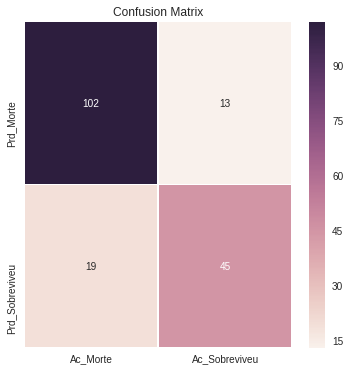

In [29]:
predictions = clf.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold


def run_kfold(clf):
    
    kf = KFold(n_splits=7, shuffle=True)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(data):
        fold += 1
        X_train2, X_test2 = X_all.values[train_index], X_all.values[test_index]
        y_train2, y_test2 = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train2, y_train2)
        predictions = clf.predict(X_test2)
        accuracy = accuracy_score(y_test2, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

mat = confusion_matrix(y_test,predictions)

f,ax = plt.subplots(figsize=(6, 6))
plt.title('Confusion Matrix'.decode('utf-8'))
sns.heatmap(mat, annot=True, linewidths=.5, fmt= 'd',ax=ax, 
            xticklabels=['Ac_Morte', 'Ac_Sobreviveu'], yticklabels=['Prd_Morte', 'Prd_Sobreviveu'])